In [5]:
!pip uninstall -y sentence-transformers
!pip install -q sentence-transformers==2.2.2
!pip install -q transformers==4.41.2
!pip install -q --upgrade huggingface_hub==0.23.4
!pip install -q sentence-transformers==2.2.2


Found existing installation: sentence-transformers 2.2.2
Uninstalling sentence-transformers-2.2.2:
  Successfully uninstalled sentence-transformers-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 7.9 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.23.4 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
diffusers 0.34.0 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.23.4 which is incompatible.
peft 0.16.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.23.4 which is incompatible.
gradio 5.38.1 requires huggingface-hub>=0.28.1, but you have huggingface-hub 0.23.4 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydant

In [2]:
# Load all libraries, set parameters, and prepare notebook environment

import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# clustering
from sklearn.cluster import KMeans

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# install keybert if needed
!pip install keybert > /dev/null
from keybert import KeyBERT
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Parameters (tune these)
CLEANED_CSV = "/kaggle/input/dataset01/cleaned_data.csv"
EMB_PATH = "text_embeddings.npy"
CLUSTERED_CSV = "clustered_reddit_data.csv"
TREND_REPORT = "trend_report.csv"


N_CLUSTERS = 12
RECENT_DAYS = 7
ENGAGEMENT_WEIGHT_COMMENTS = 2
TOP_K_KEYWORDS = 12

# Display settings
pd.set_option('display.max_colwidth', 200)
sns.set_style('whitegrid')


In [3]:
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [4]:
from sentence_transformers import SentenceTransformer

try:
    # Try the main model
    model = SentenceTransformer("all-MiniLM-L6-v2")
except Exception as e:
    print("⚠️ Issue loading MiniLM. Falling back to alternative model.", e)
    # Use a working local mirror (will auto-download)
    model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

print("✅ Model loaded successfully!")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded successfully!


## Load Dataset

In [5]:
# Read the cleaned CSV and ensure columns are valid.

assert os.path.exists(CLEANED_CSV), f"File not found: {CLEANED_CSV}"

df = pd.read_csv(CLEANED_CSV)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure required columns exist
for col in ['subreddit','processed_text','score','num_comments','created_utc']:
    if col not in df.columns:
        raise ValueError(f"Required column missing: {col}")

# Parse datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
df = df.dropna(subset=['processed_text']).reset_index(drop=True)

print("After cleaning:", df.shape)
df.head(3)


Initial shape: (20925, 5)
Columns: ['subreddit', 'processed_text', 'score', 'num_comments', 'created_utc']
After cleaning: (20925, 5)


,subreddit,processed_text,score,num_comments,created_utc
0,AskReddit,whats something thats happen arent aware whats something thats happen arent aware,6896,4599,2025-10-29 22:55:16
1,AskReddit,girl used post nude make feel nsfw girl used post nude make feel,2420,874,2025-10-30 04:03:04
2,AskReddit,last text written gravestone say last text written gravestone say,3101,12834,2025-10-29 23:00:18


## Generate or Load Embeddings

In [7]:
# Compute text embeddings using SentenceTransformer or load precomputed ones.
EMBEDDING_MODEL="all-MiniLM-L6-v2"
if os.path.exists(EMB_PATH):
    print("Loading existing embeddings:", EMB_PATH)
    embeddings = np.load(EMB_PATH)
else:
    print("Computing embeddings using:", EMBEDDING_MODEL)
    model = SentenceTransformer(EMBEDDING_MODEL)
    texts = df['processed_text'].astype(str).tolist()
    embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)
    np.save(EMB_PATH, embeddings)
    print("Saved embeddings to:", EMB_PATH)

print("Embeddings shape:", embeddings.shape)


Computing embeddings using: all-MiniLM-L6-v2


Batches:   0%|          | 0/327 [00:00<?, ?it/s]

Saved embeddings to: text_embeddings.npy
Embeddings shape: (20925, 384)


## Clustering

In [8]:
# Apply KMeans to group similar topics based on semantic embeddings.

print("Running KMeans with", N_CLUSTERS, "clusters")
km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = km.fit_predict(embeddings)
df['cluster'] = labels

print("Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

df.to_csv(CLUSTERED_CSV, index=False)
print("Saved clustered data to:", CLUSTERED_CSV)


Running KMeans with 12 clusters
Cluster distribution:
cluster
0     2909
1     3585
2     1530
3     2079
4     1526
5     1953
6      309
7     1583
8     1169
9     1075
10    1648
11    1559
Name: count, dtype: int64
Saved clustered data to: clustered_reddit_data.csv


## Trend Detection Logic

In [9]:
# Detect which clusters are gaining momentum recently.

df['engagement'] = df['score'].fillna(0) + ENGAGEMENT_WEIGHT_COMMENTS * df['num_comments'].fillna(0)

now = df['created_utc'].max() if df['created_utc'].notna().any() else pd.Timestamp.now()
recent_thresh = now - pd.Timedelta(days=RECENT_DAYS)
print("Current time:", now, "| Recent threshold:", recent_thresh)

df_recent = df[df['created_utc'] >= recent_thresh]
print("Recent posts:", len(df_recent))

recent_stats = df_recent.groupby('cluster').agg(
    recent_count=('processed_text','count'),
    recent_engagement=('engagement','sum')
).reset_index()

baseline_start = recent_thresh - pd.Timedelta(days=4*RECENT_DAYS)
df_prev = df[(df['created_utc'] >= baseline_start) & (df['created_utc'] < recent_thresh)]
prev_stats = df_prev.groupby('cluster').agg(prev_count=('processed_text','count')).reset_index()

trend_df = recent_stats.merge(prev_stats, on='cluster', how='left').fillna(0)
trend_df['growth_ratio'] = (trend_df['recent_count'] + 1) / (trend_df['prev_count'] + 1)
trend_df = trend_df.sort_values(['growth_ratio','recent_count'], ascending=[False, False]).reset_index(drop=True)
trend_df['rank'] = trend_df.index + 1

trend_df.head(12)


Current time: 2025-10-30 18:40:12 | Recent threshold: 2025-10-23 18:40:12
Recent posts: 6163


,cluster,recent_count,recent_engagement,prev_count,growth_ratio,rank
0,4,454,1216870,459,0.989130,1
1,8,428,482346,434,0.986207,2
2,11,590,871127,632,0.933649,3
3,9,431,472458,462,0.933045,4
4,5,639,389528,754,0.847682,5
5,3,621,2119260,830,0.748496,6
6,1,1137,4303403,1521,0.747700,7
7,6,13,4641,18,0.736842,8
8,0,755,1598818,1099,0.687273,9
9,2,510,693234,765,0.667102,10


## Keyword Extraction (KeyBERT)

In [10]:
# Extract multi-word topics (semantic phrases) instead of random tokens.

kw_model = KeyBERT(model='all-MiniLM-L6-v2')
cluster_keywords = []

for cluster_id in sorted(df['cluster'].unique()):
    cluster_texts = df[df['cluster'] == cluster_id]['processed_text'].dropna().tolist()
    combined_text = " ".join(cluster_texts)
    if not combined_text.strip():
        cluster_keywords.append({'cluster': cluster_id, 'top_keywords': ''})
        continue

    keywords = kw_model.extract_keywords(
        combined_text,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=TOP_K_KEYWORDS
    )

    filtered_keywords = [
        kw for kw, score in keywords
        if len(kw.split()) > 1 or kw.lower() not in ENGLISH_STOP_WORDS
    ]

    cluster_keywords.append({
        'cluster': cluster_id,
        'top_keywords': ", ".join(filtered_keywords)
    })

# Merge keywords into trend_df
keywords_df = pd.DataFrame(cluster_keywords)
trend_df = trend_df.merge(keywords_df, on='cluster', how='left')
trend_df.to_csv(TREND_REPORT, index=False)

print("✅ Trend report saved to:", TREND_REPORT)
trend_df.head(10)


✅ Trend report saved to: trend_report.csv


,cluster,recent_count,recent_engagement,prev_count,growth_ratio,rank,top_keywords
0,4,454,1216870,459,0.989130,1,"thing physically attractive, compliment body style, sexualizing look, mainstream beauty trend, compliment body, beauty trend, girl trend need, attractive look matter, social medium beauty, attract..."
1,8,428,482346,434,0.986207,2,"involves trisha paytas, trisha paytas literally, trisha paytas strike, trisha paytas, heard trisha paytas, work know anime, modern anime industry, work anime, knowledge come anime, anime opportuni..."
2,11,590,871127,632,0.933649,3,"movie series care, saddest death series, series whats saddest, doctor stranges, watched life list, saw doctor mystery, medical drama recommendation, watching crappy medical, medical drama, fan med..."
3,9,431,472458,462,0.933045,4,"mean grammys best, song unpopular opinion, mean hot album, popular music today, single mean grammys, song opinion havent, song unpopular, beyonc uncultured pop, popular music worse, music nicki mi..."
4,5,639,389528,754,0.847682,5,"marriage want therapy, sexual thought life, wanting love truly, talk sex life, spend life sexual, life sex whats, need woman life, want sex married, desire life partner, sex life ask, life sexual ..."
5,3,621,2119260,830,0.748496,6,"misunderstood thing nuclear, whats misunderstood thing, widely misunderstood, whats misunderstood, power whats misunderstood, political reality insecure, amplification politics twitter, controvers..."
6,1,1137,4303403,1521,0.747700,7,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
7,6,13,4641,18,0.736842,8,"trending subreddits rgeologyporn, trending subreddits rsciencelaboratory, trending subreddits rgenreexplain, trending subreddits rthelastkingdom, trending subreddits rthanksmanagement, spherical t..."
8,0,755,1598818,1099,0.687273,9,"reappearance century, decade data, internet year, widespread internet, change past decade, decade idea idea, decade old account, booted decade idea, going widespread internet, make reappearance ce..."
9,2,510,693234,765,0.667102,10,"halo gaming, game including halo, game playstation halo, halo game including, halo game, new halo game, videogame boring xbox, consider era gaming, term gaming prevalent, metagame term gaming, gam..."


## Identify and Inspect Top Trends

In [11]:
TOP_N = 6
top_trending = trend_df.sort_values(['growth_ratio','recent_count'], ascending=[False, False]).head(TOP_N)

print("🔥 Top Trending Topics:\n")
for idx, row in top_trending.iterrows():
    print(f"Rank {row['rank']}: Cluster {int(row['cluster'])}")
    print(f"Growth Ratio: {row['growth_ratio']:.2f} | Recent Posts: {int(row['recent_count'])}")
    print("Top Keywords:", row['top_keywords'])
    print("-"*80)


🔥 Top Trending Topics:

Rank 1: Cluster 4
Growth Ratio: 0.99 | Recent Posts: 454
Top Keywords: thing physically attractive, compliment body style, sexualizing look, mainstream beauty trend, compliment body, beauty trend, girl trend need, attractive look matter, social medium beauty, attractive whats odd, physically attractive whats, beauty trend mainstream
--------------------------------------------------------------------------------
Rank 2: Cluster 8
Growth Ratio: 0.99 | Recent Posts: 428
Top Keywords: involves trisha paytas, trisha paytas literally, trisha paytas strike, trisha paytas, heard trisha paytas, work know anime, modern anime industry, work anime, knowledge come anime, anime opportunity expand, job anime, deal trisha paytas
--------------------------------------------------------------------------------
Rank 3: Cluster 11
Growth Ratio: 0.93 | Recent Posts: 590
Top Keywords: movie series care, saddest death series, series whats saddest, doctor stranges, watched life list, 

## Visualization (Trend Graph)

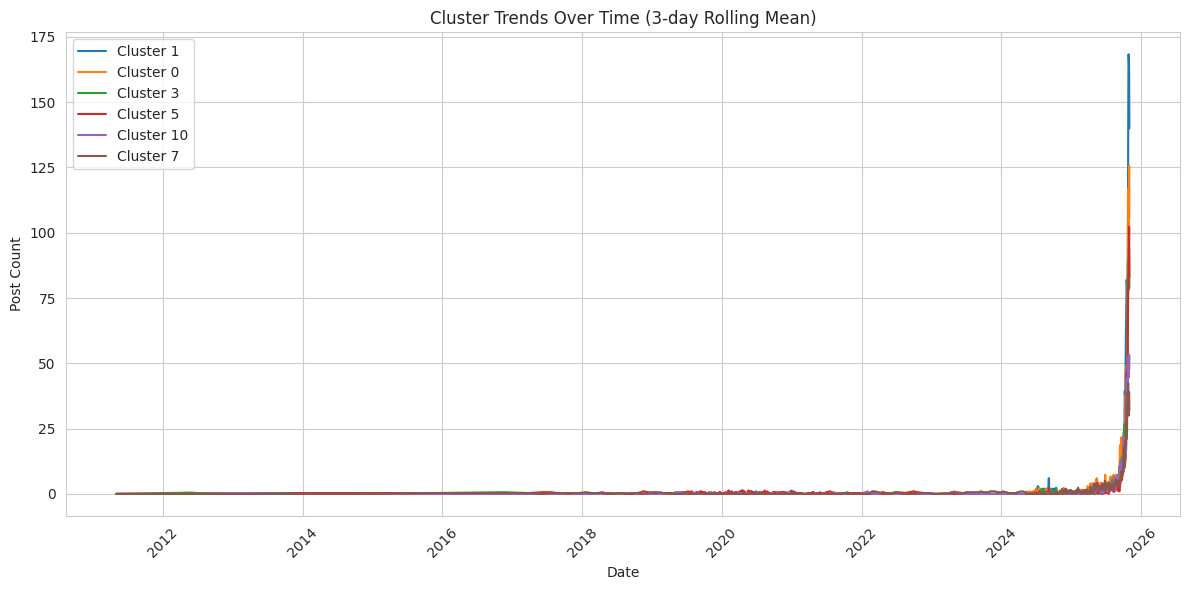

In [12]:
df['date'] = pd.to_datetime(df['created_utc']).dt.date
trend_time = df.groupby(['date','cluster']).size().unstack(fill_value=0)

top_clusters = df['cluster'].value_counts().head(6).index.tolist()
plt.figure(figsize=(12,6))
for c in top_clusters:
    series = trend_time[c] if c in trend_time.columns else pd.Series(0, index=trend_time.index)
    series.rolling(window=3, min_periods=1).mean().plot(label=f"Cluster {c}")
plt.legend()
plt.title("Cluster Trends Over Time (3-day Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Word Cloud for Top Cluster

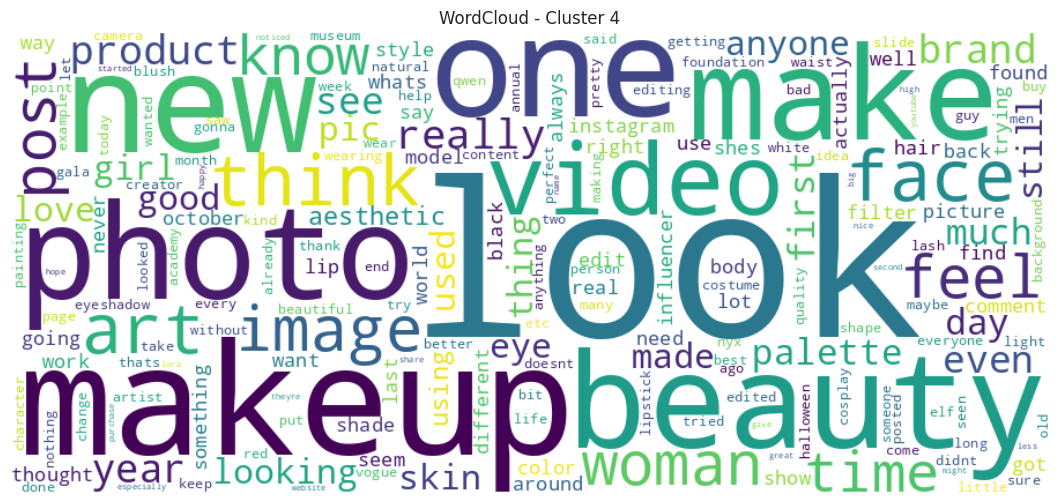

🔝 Sample Posts from Cluster 4


,subreddit,processed_text,score,num_comments
1,AskReddit,girl used post nude make feel nsfw girl used post nude make feel,2420,874
29,AskReddit,annoying trait notice annoying trait notice,25,75
44,AskReddit,would see insult take compliment would see insult take compliment,105,392
81,AskReddit,whats best sexual compliment youve received whats best sexual compliment youve received,3777,3406
83,AskReddit,whats sexiest sfw thing youve seen someone whats sexiest sfw thing youve seen someone,2956,1830
101,AskReddit,whats odd thing find physically attractive whats odd thing find physically attractive,1430,3248
144,AskReddit,find attractive others find attractive others,403,364
180,AskReddit,woman feature man automatically notice without thought everytime see woman feature man automatically notice without thought everytime see,136,339
185,AskReddit,look mirror see look mirror see,125,430
186,AskReddit,celebrity fame make sense celebrity fame make sense,130,525


In [13]:
def show_wordcloud_for_cluster(cluster_id, max_words=150):
    texts = " ".join(df[df['cluster']==cluster_id]['processed_text'].astype(str).tolist())
    if not texts.strip():
        print("No text for cluster", cluster_id)
        return
    wc = WordCloud(width=900, height=400, background_color='white', collocations=False).generate(texts)
    plt.figure(figsize=(14,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Cluster {cluster_id}")
    plt.show()

top_cluster_id = int(top_trending.iloc[0]['cluster'])
show_wordcloud_for_cluster(top_cluster_id)

top_cluster_posts = df[df['cluster']==top_cluster_id][['subreddit','processed_text','score','num_comments']].head(10)
print(f"🔝 Sample Posts from Cluster {top_cluster_id}")
display(top_cluster_posts)


## Save Final Clustered Data

In [14]:
df['cluster_keywords'] = df['cluster'].apply(
    lambda c: trend_df.loc[trend_df['cluster']==c, 'top_keywords'].values[0]
    if c in trend_df['cluster'].values else ""
)

outpath = "clustered_reddit_with_keywords.csv"
df.to_csv(outpath, index=False)
print("✅ Saved clustered data with semantic keywords to:", outpath)


✅ Saved clustered data with semantic keywords to: clustered_reddit_with_keywords.csv


In [15]:
df = pd.read_csv("/kaggle/working/clustered_reddit_with_keywords.csv")
df.head(10)

,subreddit,processed_text,score,num_comments,created_utc,cluster,engagement,date,cluster_keywords
0,AskReddit,whats something thats happen arent aware whats something thats happen arent aware,6896,4599,2025-10-29 22:55:16,1,16094,2025-10-29,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
1,AskReddit,girl used post nude make feel nsfw girl used post nude make feel,2420,874,2025-10-30 04:03:04,4,4168,2025-10-30,"thing physically attractive, compliment body style, sexualizing look, mainstream beauty trend, compliment body, beauty trend, girl trend need, attractive look matter, social medium beauty, attract..."
2,AskReddit,last text written gravestone say last text written gravestone say,3101,12834,2025-10-29 23:00:18,1,28769,2025-10-29,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
3,AskReddit,make zero horny instant make zero horny instant,3886,2810,2025-10-29 20:33:36,1,9506,2025-10-29,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
4,AskReddit,assume disgusting tried assume disgusting tried,814,2204,2025-10-30 03:53:50,1,5222,2025-10-30,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
5,AskReddit,whats finally saw doctor mystery symptom weeksmonthsyears turned way simpler feared story finally made outcome whats finally saw doctor mystery symptom weeksmonthsyears turned way simpler feared s...,1423,865,2025-10-30 00:18:57,11,3153,2025-10-30,"movie series care, saddest death series, series whats saddest, doctor stranges, watched life list, saw doctor mystery, medical drama recommendation, watching crappy medical, medical drama, fan med..."
6,AskReddit,amateur athlete whats there level shit experience sport amateur athlete whats there level shit experience sport,688,769,2025-10-30 03:01:15,1,2226,2025-10-30,"favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word wh..."
7,AskReddit,make ask many sexual question askreddit make ask many sexual question askreddit,759,179,2025-10-30 00:49:17,5,1117,2025-10-30,"marriage want therapy, sexual thought life, wanting love truly, talk sex life, spend life sexual, life sex whats, need woman life, want sex married, desire life partner, sex life ask, life sexual ..."
8,AskReddit,youre sent year past bring one item take youre sent year past bring one item take,357,1020,2025-10-30 03:45:56,0,2397,2025-10-30,"reappearance century, decade data, internet year, widespread internet, change past decade, decade idea idea, decade old account, booted decade idea, going widespread internet, make reappearance ce..."
9,AskReddit,skill could offer apocalypse skill could offer apocalypse,133,535,2025-10-30 07:56:33,8,1203,2025-10-30,"involves trisha paytas, trisha paytas literally, trisha paytas strike, trisha paytas, heard trisha paytas, work know anime, modern anime industry, work anime, knowledge come anime, anime opportuni..."


In [17]:
trending = df.groupby('cluster_keywords').size().sort_values(ascending=False).head(10)
print(trending)


cluster_keywords
favorite south park, south park quote, south park, death whats weirdest, gonna whats society, say super weird, whats strangest snobbery, word whats, dinosaur whats, living whats creepiest, word whats funniest, whats weirdest thing                                                                              3585
reappearance century, decade data, internet year, widespread internet, change past decade, decade idea idea, decade old account, booted decade idea, going widespread internet, make reappearance century, term technology world, year monetized thing                                                              2909
misunderstood thing nuclear, whats misunderstood thing, widely misunderstood, whats misunderstood, power whats misunderstood, political reality insecure, amplification politics twitter, controversial social medium, trump maga semantics, post controversial social, labeled scam reality, truth social tweet    2079
marriage want therapy, sexual thought life, 